In [1]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_graphml('../../scripture_graph.graphml')

In [3]:
# Count the fraction of reciprocal references...there seem to be a lot of them.
unique = []
for a, b in graph.edges:
    if (b, a) not in graph.edges:
        unique.append((a, b))
print(len(unique), len(graph.edges), len(unique) / len(graph.edges), 1 - len(unique) / len(graph.edges))

8020 45880 0.17480383609415867 0.8251961639058414


# Reference Counts

In [4]:
len(graph.nodes)

41995

In [5]:
len(graph.edges)

45880

In [27]:
rows = []
# NOTE(kearnes): We are only considering "in" references.
for node, degree in graph.in_degree():
    row = {'node': node, 'degree': degree}
    row.update(graph.nodes[node])
    rows.append(row)
degree = pd.DataFrame(rows)
print(degree.shape)
degree.head()

(41995, 6)


,node,degree,volume,book,chapter,verse
0,1 Chr. 1:1,0,Old Testament,1 Chr.,1,1
1,1 Chr. 1:2,0,Old Testament,1 Chr.,1,2
2,1 Chr. 1:3,0,Old Testament,1 Chr.,1,3
3,1 Chr. 1:4,2,Old Testament,1 Chr.,1,4
4,1 Chr. 1:5,0,Old Testament,1 Chr.,1,5


In [28]:
alone = (degree.degree == 0).sum()
alone / len(degree)

0.5576378140254792

In [29]:
count = (degree.degree >= 1) & (degree.degree <= 5)
count.sum() / len(degree)

0.4071913323014645

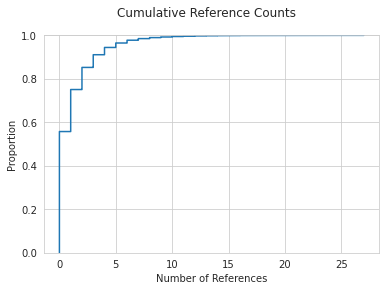

In [71]:
sns.set_style('whitegrid')

fig, ax = subplots()
sns.ecdfplot(data=degree, x='degree', ax=ax)
suptitle('Cumulative Reference Counts')
ax.set_xlabel('Number of References')
fig.savefig('count-cdf.png', dpi=300, bbox_inches='tight')

In [31]:
sort = degree.sort_values('degree', ascending=False)
for volume in sort.volume.unique():
    print(sort[sort.volume == volume].head())

            node  degree                  volume book  chapter  verse
36839   D&C 17:1      27  Doctrine and Covenants  D&C       17      1
35494   D&C 1:38      27  Doctrine and Covenants  D&C        1     38
35470   D&C 1:14      24  Doctrine and Covenants  D&C        1     14
38772  D&C 88:63      21  Doctrine and Covenants  D&C       88     63
35472   D&C 1:16      21  Doctrine and Covenants  D&C        1     16
              node  degree          volume   book  chapter  verse
31384  1 Ne. 17:35      25  Book of Mormon  1 Ne.       17     35
39664    Hel. 12:3      25  Book of Mormon   Hel.       12      3
32109  2 Ne. 25:20      23  Book of Mormon  2 Ne.       25     20
31439  1 Ne. 19:10      23  Book of Mormon  1 Ne.       19     10
32472   2 Ne. 9:28      20  Book of Mormon  2 Ne.        9     28
             node  degree                volume   book  chapter  verse
41051  Moses 6:57      23  Pearl of Great Price  Moses        6     57
40811   Moses 1:6      18  Pearl of Great 

# Reference Patterns

In [11]:
# Look at pairs of standard works (or even books). What are the cross-reference patterns?

# TODO:
# * Compare to normalization by the number of verses (relative reference propensity). The absolute is interesting too.

In [35]:
volume_totals = collections.defaultdict(int)
for node in graph.nodes:
    volume_totals[graph.nodes[node]['volume']] += 1
volume_totals

defaultdict(int,
            {'Old Testament': 23145,
             'New Testament': 7957,
             'Book of Mormon': 6604,
             'Pearl of Great Price': 635,
             'Doctrine and Covenants': 3654})

In [33]:
volume_degree = {}
for key in volume_totals:
    mask = degree.volume == key
    volume_degree[key] = degree[mask].degree.values.sum()
volume_degree

{'Old Testament': 16986,
 'New Testament': 7317,
 'Book of Mormon': 12234,
 'Pearl of Great Price': 1412,
 'Doctrine and Covenants': 7931}

In [37]:
relative_volume_degree = {}
for key in volume_totals:
    relative_volume_degree[key] = volume_degree[key] / volume_totals[key]
relative_volume_degree

{'Old Testament': 0.733895009721322,
 'New Testament': 0.919567676259897,
 'Book of Mormon': 1.8525136281041792,
 'Pearl of Great Price': 2.2236220472440946,
 'Doctrine and Covenants': 2.1704980842911876}

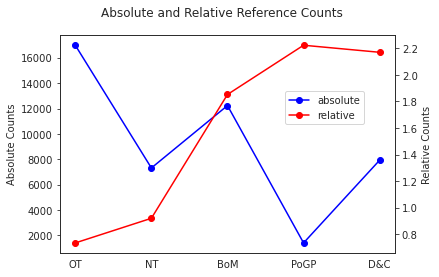

In [70]:
sns.set_style('white')
fig, ax = subplots()
ax.plot(volume_degree.values(), '-o', color='blue', label='absolute')
ax.set_ylabel('Absolute Counts')
ax2 = ax.twinx()
ax2.plot(relative_volume_degree.values(), '-o', color='red', label='relative')
ax2.set_ylabel('Relative Counts')
ax.set_xticks(range(5))
ax.set_xticklabels([graph_lib.VOLUMES_SHORT[key] for key in volume_degree])
figlegend(loc=(0.65, 0.55))
suptitle('Absolute and Relative Reference Counts')
fig.savefig('count-lines.png', dpi=300, bbox_inches='tight')

In [13]:
volume_counts = collections.defaultdict(int)
book_counts = collections.defaultdict(int)
for tail in graph.nodes:
    tail_volume = graph.nodes[tail]['volume']
    tail_book = graph.nodes[tail]['book']
    for head, _ in graph.in_edges(tail):
        head_volume = graph.nodes[head]['volume']
        head_book = graph.nodes[head]['book']
        volume_counts[(head_volume, tail_volume)] += 1
        book_counts[(head_book, tail_book)] += 1

rows = []
for (head, tail), count in volume_counts.items():
    rows.append({'head': head, 'tail': tail, 'count': count})
volume_data = pd.DataFrame(rows)
print(volume_data.head())
        
rows = []
for (head, tail), count in book_counts.items():
    rows.append({'head': head, 'tail': tail, 'count': count})
book_data = pd.DataFrame(rows)
print(book_data.head())

                     head           tail  count
0           Old Testament  Old Testament  11244
1    Pearl of Great Price  Old Testament    369
2          Book of Mormon  Old Testament   2435
3  Doctrine and Covenants  Old Testament   1840
4           New Testament  Old Testament   1098
     head    tail  count
0    Gen.  1 Chr.     31
1   Moses  1 Chr.      3
2   Ether  1 Chr.      2
3    Abr.  1 Chr.      1
4  1 Sam.  1 Chr.     19


<AxesSubplot:xlabel='tail', ylabel='head'>

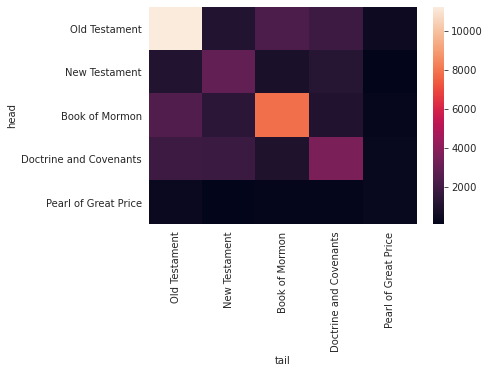

In [20]:
order = []
for volume in graph_lib.VOLUMES.keys():
    if volume == 'Study Helps':
        continue
    order.append(volume)
df = volume_data.pivot('head', 'tail', 'count').reindex(index=order, columns=order)
sns.heatmap(df)

In [21]:
data = df.values
text = np.zeros_like(data, dtype=object)
for i in range(len(order)):
    i_short = graph_lib.VOLUMES_SHORT[order[i]]
    for j in range(len(order)):
        j_short = graph_lib.VOLUMES_SHORT[order[j]]
        text[i, j] = f'{i_short} → {j_short}: {data[i, j]}'
print(repr(np.flip(data, axis=0)))
print(repr(np.flip(text, axis=0)))

array([[  369,   102,   173,   176,   322],
       [ 1840,  1825,   991,  3591,   305],
       [ 2435,  1377,  7867,  1059,   256],
       [ 1098,  2911,   858,  1250,    84],
       [11244,  1102,  2345,  1855,   445]])
array([['PoGP → OT: 369', 'PoGP → NT: 102', 'PoGP → BoM: 173',
        'PoGP → D&C: 176', 'PoGP → PoGP: 322'],
       ['D&C → OT: 1840', 'D&C → NT: 1825', 'D&C → BoM: 991',
        'D&C → D&C: 3591', 'D&C → PoGP: 305'],
       ['BoM → OT: 2435', 'BoM → NT: 1377', 'BoM → BoM: 7867',
        'BoM → D&C: 1059', 'BoM → PoGP: 256'],
       ['NT → OT: 1098', 'NT → NT: 2911', 'NT → BoM: 858',
        'NT → D&C: 1250', 'NT → PoGP: 84'],
       ['OT → OT: 11244', 'OT → NT: 1102', 'OT → BoM: 2345',
        'OT → D&C: 1855', 'OT → PoGP: 445']], dtype=object)


In [25]:
norm = np.asarray(list(volume_totals.values()), dtype=int).reshape((1, -1))
print(norm)
data = df.values / norm
print(repr(data))
text = np.zeros_like(data, dtype=object)
for i in range(len(order)):
    i_short = graph_lib.VOLUMES_SHORT[order[i]]
    for j in range(len(order)):
        j_short = graph_lib.VOLUMES_SHORT[order[j]]
        value = np.round(data[i, j], 2)
        text[i, j] = f'{i_short} → {j_short}: {value}'
print(repr(np.flip(data, axis=0)))
print(repr(np.flip(text, axis=0)))

[[23145  7957  6604   635  3654]]
array([[0.48580687, 0.13849441, 0.35508783, 2.92125984, 0.12178435],
       [0.04744005, 0.3658414 , 0.12992126, 1.96850394, 0.02298851],
       [0.10520631, 0.17305517, 1.19124773, 1.66771654, 0.07006021],
       [0.07949881, 0.2293578 , 0.15006057, 5.65511811, 0.08347017],
       [0.01594297, 0.0128189 , 0.02619624, 0.27716535, 0.08812261]])
array([[0.01594297, 0.0128189 , 0.02619624, 0.27716535, 0.08812261],
       [0.07949881, 0.2293578 , 0.15006057, 5.65511811, 0.08347017],
       [0.10520631, 0.17305517, 1.19124773, 1.66771654, 0.07006021],
       [0.04744005, 0.3658414 , 0.12992126, 1.96850394, 0.02298851],
       [0.48580687, 0.13849441, 0.35508783, 2.92125984, 0.12178435]])
array([['PoGP → OT: 0.02', 'PoGP → NT: 0.01', 'PoGP → BoM: 0.03',
        'PoGP → D&C: 0.28', 'PoGP → PoGP: 0.09'],
       ['D&C → OT: 0.08', 'D&C → NT: 0.23', 'D&C → BoM: 0.15',
        'D&C → D&C: 5.66', 'D&C → PoGP: 0.08'],
       ['BoM → OT: 0.11', 'BoM → NT: 0.17', 'Bo

<AxesSubplot:xlabel='tail', ylabel='head'>

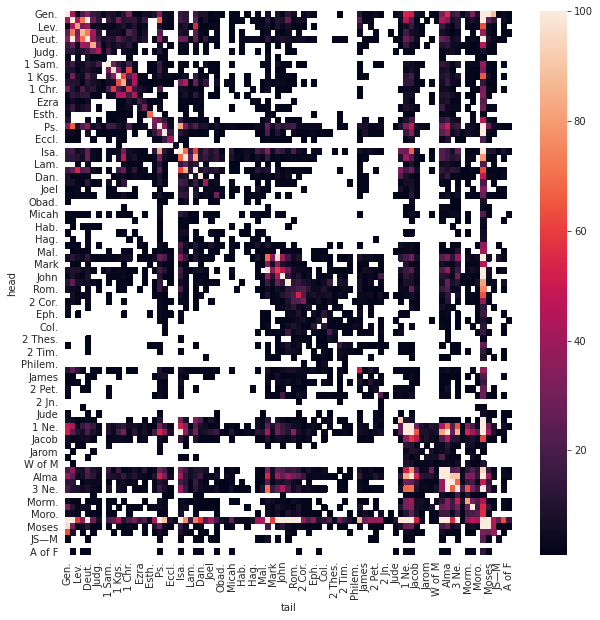

In [18]:
order = []
for volume, books in graph_lib.VOLUMES.items():
    if volume == 'Study Helps':
        continue
    order.extend(books)
df = book_data.pivot('head', 'tail', 'count').reindex(index=order, columns=order)
figure(figsize=(10, 10))
sns.heatmap(df, vmax=100)